<a href="https://colab.research.google.com/github/mel418/CECS456_Melody_VGG16/blob/main/VGG16_Animals10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG16 Transfer Learning for Animals10 Classification
**CECS 456 - Deep Learning Project**

Melody Gatan

**Dataset:** Animals10 (10 animal categories)

**Model:** VGG16 with Transfer Learning

## 1. Setup and Imports

In [1]:
# Core libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from PIL import Image

# Utilities
import os
import time
import numpy as np
from tqdm import tqdm

# Visualization and metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if device.type == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cuda
GPU: NVIDIA A100-SXM4-80GB


## 2. Mount Google Drive and Setup Paths

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to project folder
%cd '/content/drive/MyDrive/CECS456_Project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CECS456_Project


## 4. Custom Dataset Class

In [3]:
class Animals10Dataset(Dataset):
    """Custom dataset class for Animals10."""

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Get class names from folder names
        self.classes = sorted([d for d in os.listdir(root_dir)
                               if os.path.isdir(os.path.join(root_dir, d))])
        print(f"Found classes: {self.classes}")

        # Load all image paths and labels
        for idx, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(os.path.join(class_path, img_name))
                    self.labels.append(idx)

        print(f"Total images loaded: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            return torch.zeros(3, 224, 224), label

## 5. Data Transformations and Augmentation

In [4]:
# Training transformations (with data augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test transformations (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 6. Load and Split Dataset

In [5]:
# Dataset path (using local storage)
dataset_path = '/content/drive/MyDrive/CECS456_Project/raw-img'

# Create full dataset
full_dataset = Animals10Dataset(root_dir=dataset_path, transform=train_transform)

# Split: 70% train, 15% validation, 15% test
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

# Apply appropriate transforms to validation and test sets
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

print(f"\n📊 Dataset Split:")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Found classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Total images loaded: 26179

📊 Dataset Split:
Training samples: 18325
Validation samples: 3926
Test samples: 3928


## 7. Create Data Loaders

In [6]:
BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Batch size: 64
Training batches: 287
Validation batches: 62
Test batches: 62


## 8. Visualize Sample Images (Optional)

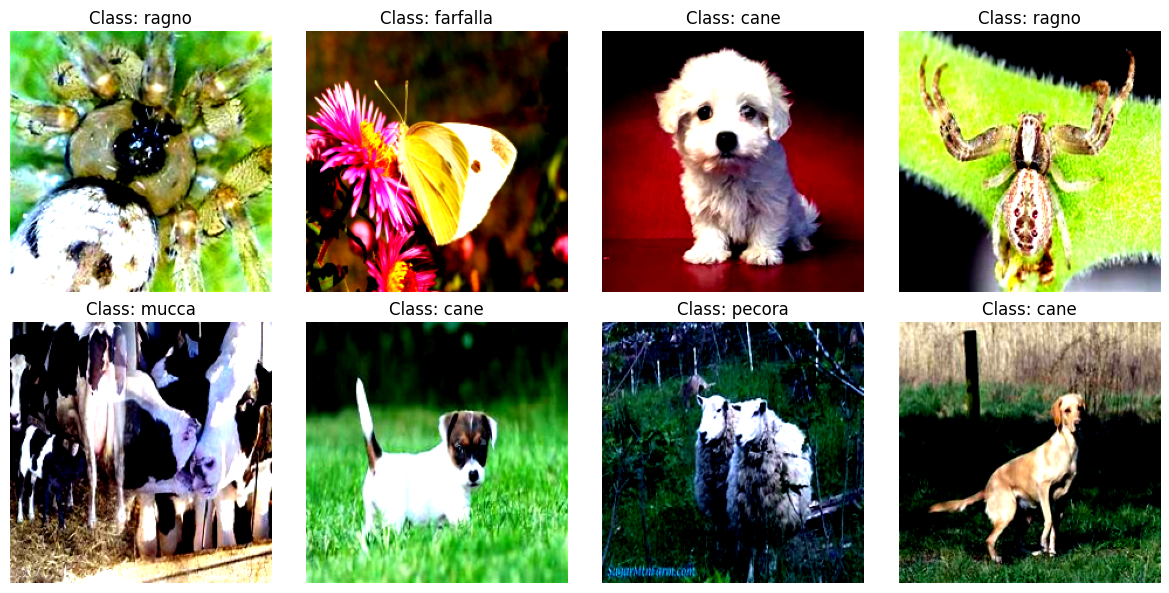

In [7]:
def imshow(img, title):
    """Display an image with title."""
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display 8 sample images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        plt.sca(ax)
        imshow(images[i].cpu(), f"Class: {full_dataset.classes[labels[i]]}")
plt.tight_layout()
plt.show()

## 9. Define VGG16 Model with Transfer Learning

In [8]:
class VGGModel(nn.Module):
    """VGG16 model with transfer learning for Animals10 classification."""

    def __init__(self, num_classes=10, dropout=0.5):
        super(VGGModel, self).__init__()

        # Load pre-trained VGG16
        self.vgg = models.vgg16(pretrained=True)

        # Freeze convolutional layers (use pre-trained features)
        for param in self.vgg.features.parameters():
            param.requires_grad = False

        # Replace classifier for 10 classes
        self.vgg.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        return self.vgg(x)

# Initialize model
model = VGGModel(num_classes=10).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n🔧 Model Architecture: VGG16")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



🔧 Model Architecture: VGG16
Total parameters: 134,301,514
Trainable parameters: 119,586,826
Frozen parameters: 14,714,688


## 10. Training Functions

In [9]:
def train_one_epoch(model, loader, criterion, optimizer):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def validate(model, loader, criterion):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

## 11. Training Configuration and Main Training Loop

In [10]:
# Hyperparameters
EPOCHS = 10
LEARNING_RATE = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# For tracking metrics
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("\n🚀 Starting Training...")
print("=" * 60)

start_time = time.time()

for epoch in range(EPOCHS):
    print(f"\nEpoch [{epoch+1}/{EPOCHS}]")

    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion)

    # Save metrics
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print summary
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print("-" * 60)

end_time = time.time()
training_time = end_time - start_time

print(f"\n✅ Training Complete!")
print(f"Total training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")


🚀 Starting Training...

Epoch [1/10]


Validation: 100%|██████████| 62/62 [02:07<00:00,  2.06s/it]


Train Loss: 0.6066 | Train Acc: 87.69%
Val Loss: 0.2623 | Val Acc: 93.05%
------------------------------------------------------------

Epoch [2/10]


Validation: 100%|██████████| 62/62 [00:08<00:00,  7.67it/s]


Train Loss: 0.3089 | Train Acc: 93.39%
Val Loss: 0.2755 | Val Acc: 93.96%
------------------------------------------------------------

Epoch [3/10]


Validation: 100%|██████████| 62/62 [00:08<00:00,  7.39it/s]


Train Loss: 0.3438 | Train Acc: 94.16%
Val Loss: 0.2816 | Val Acc: 94.07%
------------------------------------------------------------

Epoch [4/10]


Validation: 100%|██████████| 62/62 [00:08<00:00,  7.65it/s]


Train Loss: 0.4320 | Train Acc: 94.43%
Val Loss: 0.4772 | Val Acc: 93.50%
------------------------------------------------------------

Epoch [5/10]


Validation: 100%|██████████| 62/62 [00:08<00:00,  7.56it/s]


Train Loss: 0.4936 | Train Acc: 94.97%
Val Loss: 0.5891 | Val Acc: 93.58%
------------------------------------------------------------

Epoch [6/10]


Validation: 100%|██████████| 62/62 [00:08<00:00,  7.61it/s]


Train Loss: 0.4442 | Train Acc: 95.83%
Val Loss: 0.4512 | Val Acc: 94.50%
------------------------------------------------------------

Epoch [7/10]


Validation: 100%|██████████| 62/62 [00:08<00:00,  7.62it/s]


Train Loss: 0.3929 | Train Acc: 96.53%
Val Loss: 0.5477 | Val Acc: 94.60%
------------------------------------------------------------

Epoch [8/10]


Validation: 100%|██████████| 62/62 [00:08<00:00,  7.68it/s]


Train Loss: 0.4063 | Train Acc: 96.89%
Val Loss: 0.4970 | Val Acc: 95.54%
------------------------------------------------------------

Epoch [9/10]


Validation: 100%|██████████| 62/62 [00:08<00:00,  7.61it/s]


Train Loss: 0.3709 | Train Acc: 97.05%
Val Loss: 0.7349 | Val Acc: 95.52%
------------------------------------------------------------

Epoch [10/10]


Validation: 100%|██████████| 62/62 [00:08<00:00,  7.38it/s]

Train Loss: 0.4000 | Train Acc: 97.40%
Val Loss: 0.6011 | Val Acc: 95.19%
------------------------------------------------------------

✅ Training Complete!
Total training time: 579.73 seconds (9.66 minutes)


## 12. Plot Training History

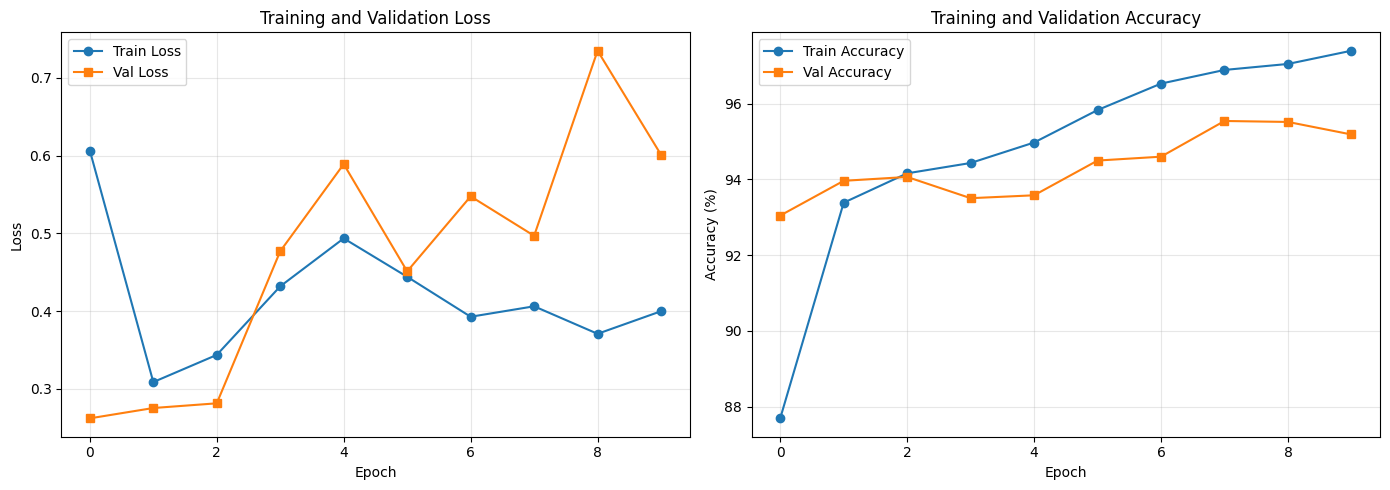

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Accuracy', marker='o')
ax2.plot(history['val_acc'], label='Val Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vgg16_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

## 13. Test Model

In [12]:
def test_model(model, test_loader):
    """Test the model and return predictions."""
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * correct / total
    return all_preds, all_labels, test_acc

print("🧪 Testing Model...")
predictions, true_labels, test_accuracy = test_model(model, test_loader)
print(f"\n📊 Test Accuracy: {test_accuracy:.2f}%")

🧪 Testing Model...


Testing: 100%|██████████| 62/62 [09:11<00:00,  8.89s/it]


📊 Test Accuracy: 95.80%


## 14. Confusion Matrix

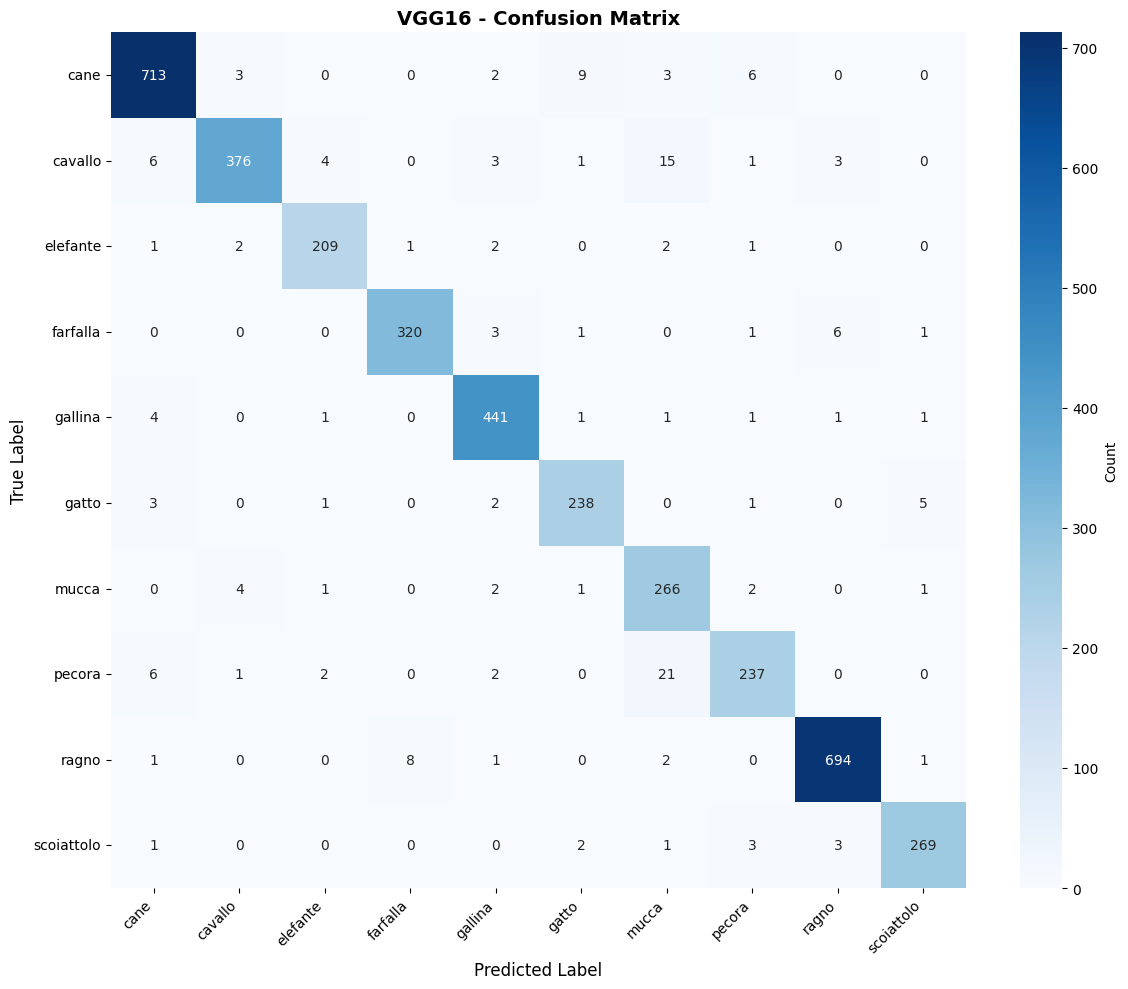


🔍 Most Confused Classes:
  cane → gatto: 9 times
  cane → pecora: 6 times
  cavallo → cane: 6 times
  cavallo → mucca: 15 times
  farfalla → ragno: 6 times
  pecora → cane: 6 times
  pecora → mucca: 21 times
  ragno → farfalla: 8 times


In [13]:
class_names = full_dataset.classes
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('VGG16 - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('vgg16_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify most confused pairs
print("\n🔍 Most Confused Classes:")
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i][j] > 5:
            print(f"  {class_names[i]} → {class_names[j]}: {cm[i][j]} times")

## 15. Classification Report

In [14]:
print("\n📋 Classification Report:")
print("=" * 70)
report = classification_report(true_labels, predictions,
                                target_names=class_names,
                                digits=3)
print(report)

# Save report
with open('vgg16_classification_report.txt', 'w') as f:
    f.write(report)


📋 Classification Report:
              precision    recall  f1-score   support

        cane      0.970     0.969     0.969       736
     cavallo      0.974     0.919     0.946       409
    elefante      0.959     0.959     0.959       218
    farfalla      0.973     0.964     0.968       332
     gallina      0.963     0.978     0.970       451
       gatto      0.941     0.952     0.946       250
       mucca      0.855     0.960     0.905       277
      pecora      0.937     0.881     0.908       269
       ragno      0.982     0.982     0.982       707
  scoiattolo      0.968     0.964     0.966       279

    accuracy                          0.958      3928
   macro avg      0.952     0.953     0.952      3928
weighted avg      0.959     0.958     0.958      3928



## 16. Per-Class Accuracy Visualization

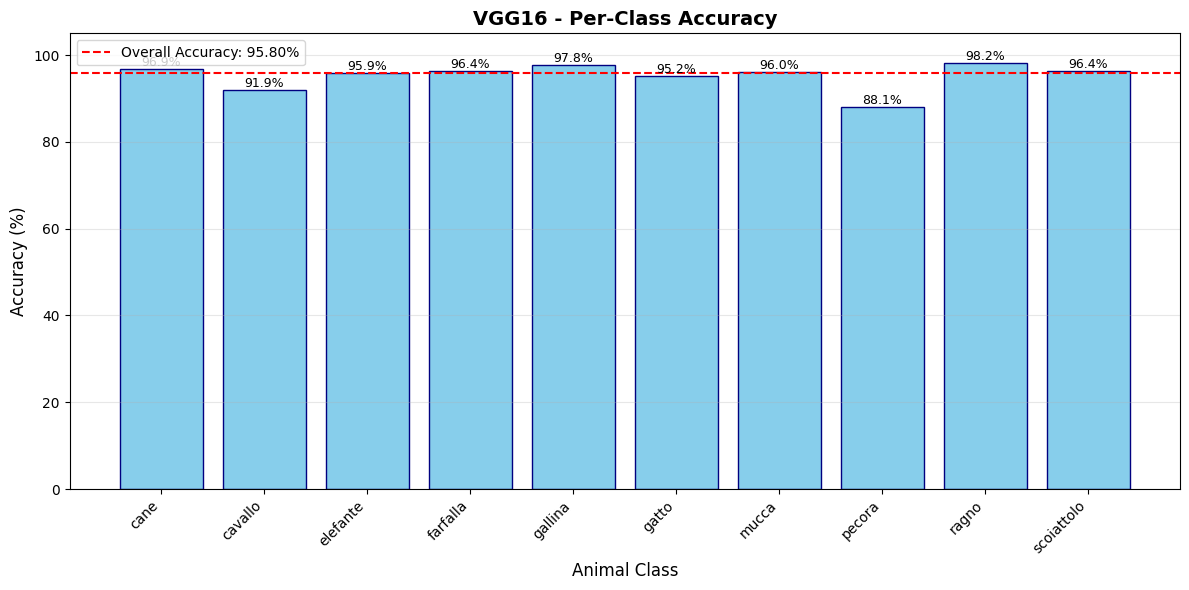

In [15]:
# Calculate per-class accuracy
class_correct = [0] * len(class_names)
class_total = [0] * len(class_names)

for pred, true in zip(predictions, true_labels):
    class_total[true] += 1
    if pred == true:
        class_correct[true] += 1

class_accuracy = [100 * c / t if t > 0 else 0
                  for c, t in zip(class_correct, class_total)]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, class_accuracy, color='skyblue', edgecolor='navy')
plt.axhline(y=test_accuracy, color='r', linestyle='--',
            label=f'Overall Accuracy: {test_accuracy:.2f}%')
plt.xlabel('Animal Class', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('VGG16 - Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 105])
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, class_accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('vgg16_per_class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

## 17. Save Model and Results

In [16]:
# Save model
model_save_path = '/content/drive/MyDrive/CECS456_Project/Melody_VGG16/vgg16_animals10.pth'
torch.save(model.state_dict(), model_save_path)
print(f"✅ Model saved to: {model_save_path}")

# Save complete results
results_file = '/content/drive/MyDrive/CECS456_Project/Melody_VGG16/vgg16_complete_results.txt'
with open(results_file, 'w') as f:
    f.write("=" * 70 + "\n")
    f.write("VGG16 MODEL - ANIMALS10 DATASET - COMPLETE RESULTS\n")
    f.write("=" * 70 + "\n\n")

    f.write("TRAINING CONFIGURATION:\n")
    f.write(f"  Model: VGG16 (pre-trained on ImageNet)\n")
    f.write(f"  Dataset: Animals10 ({len(full_dataset)} total images)\n")
    f.write(f"  Classes: {len(class_names)}\n")
    f.write(f"  Train/Val/Test split: {len(train_dataset)}/{len(val_dataset)}/{len(test_dataset)}\n")
    f.write(f"  Epochs: {EPOCHS}\n")
    f.write(f"  Batch size: {BATCH_SIZE}\n")
    f.write(f"  Learning rate: {LEARNING_RATE}\n")
    f.write(f"  Optimizer: Adam\n")
    f.write(f"  Device: {device}\n\n")

    f.write("TRAINING RESULTS:\n")
    f.write(f"  Training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)\n")
    f.write(f"  Final train accuracy: {history['train_acc'][-1]:.2f}%\n")
    f.write(f"  Final validation accuracy: {history['val_acc'][-1]:.2f}%\n")
    f.write(f"  Best validation accuracy: {max(history['val_acc']):.2f}%\n")
    f.write(f"  Test accuracy: {test_accuracy:.2f}%\n\n")

    f.write("PER-CLASS ACCURACY:\n")
    for name, acc in zip(class_names, class_accuracy):
        f.write(f"  {name}: {acc:.2f}%\n")

    f.write("\n" + "=" * 70 + "\n")
    f.write("CLASSIFICATION REPORT:\n")
    f.write("=" * 70 + "\n")
    f.write(report)

print(f"✅ Results saved to: {results_file}")
print("\n🎉 All done! Your VGG16 model is trained and evaluated.")

✅ Model saved to: /content/drive/MyDrive/CECS456_Project/Melody_VGG16/vgg16_animals10.pth
✅ Results saved to: /content/drive/MyDrive/CECS456_Project/Melody_VGG16/vgg16_complete_results.txt

🎉 All done! Your VGG16 model is trained and evaluated.


## 18. Model Summary for Report

In [17]:
vgg_summary = {
    'model_name': 'VGG16',
    'test_accuracy': test_accuracy,
    'training_time_seconds': training_time,
    'training_time_minutes': training_time / 60,
    'best_val_accuracy': max(history['val_acc']),
    'total_parameters': total_params,
    'trainable_parameters': trainable_params,
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'best_class': class_names[class_accuracy.index(max(class_accuracy))],
    'best_class_accuracy': max(class_accuracy),
    'worst_class': class_names[class_accuracy.index(min(class_accuracy))],
    'worst_class_accuracy': min(class_accuracy)
}

print("\n📊 VGG16 Summary for Report:")
print("=" * 50)
for key, value in vgg_summary.items():
    print(f"{key}: {value}")
print("=" * 50)


📊 VGG16 Summary for Report:
model_name: VGG16
test_accuracy: 95.79938900203666
training_time_seconds: 579.730455160141
training_time_minutes: 9.662174252669017
best_val_accuracy: 95.54253693326541
total_parameters: 134301514
trainable_parameters: 119586826
epochs: 10
batch_size: 64
learning_rate: 0.001
best_class: ragno
best_class_accuracy: 98.16124469589816
worst_class: pecora
worst_class_accuracy: 88.10408921933086
